# Set-up of smooth animation for faulted reservoir

Based on Model of Fabian, but modified to behave a bit more geolgically...


In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
# prepend to list to get correct gempy version
sys.path.insert(0,"../")
# sys.path.append("../")


# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
../gempy/UncertaintyAnalysisPYMC2.py:8: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


In [23]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 100,100,100],
                          path_f = os.pardir+"/input_data/FW_2_Foliations.csv", 
                          path_i = os.pardir+"/input_data/FW_2_Points.csv")


../gempy/DataManagement.py:438: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../gempy/DataManagement.py:441: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


In [24]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest": ('SecondaryReservoir','Seal', 'Reservoir', 'Overlying')},
                       order_series = ["fault", 'Rest'],
                       order_formations=['MainFault', 
                                         'SecondaryReservoir', 'Seal','Reservoir', 'Overlying',
                                         ], verbose=0) 

../gempy/DataManagement.py:438: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../gempy/DataManagement.py:441: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


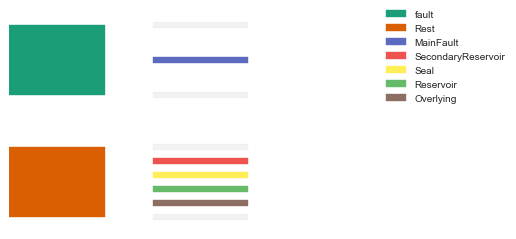

In [25]:
%matplotlib inline
gp.get_sequential_pile(geo_data)

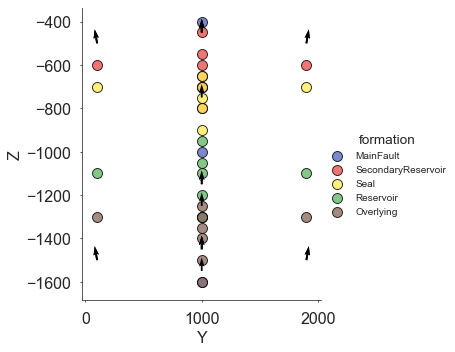

In [26]:
%matplotlib inline
gp.plot_data(geo_data, direction='x')

In [36]:
gp.plot_data_3D(geo_data)

In [28]:
interp_data = gp.InterpolatorInput(geo_data, u_grade=[3,0], dtype="float64")
print(interp_data)

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [207]:
import copy
#init = copy.deepcopy(interp_data.geo_data_res)

In [208]:
#interp_data.geo_data_res = init

In [29]:
lith_block, fault_block = gp.compute_model(interp_data)

In [30]:
 # Testing the uncertainty
np.ones_like(interp_data.geo_data_res.interfaces['Z'])*0.01*\
np.random.choice([-1,1],size = interp_data.geo_data_res.interfaces['Z'].shape[0] )

array([-0.01, -0.01, -0.01, 0.01, -0.01, -0.01, -0.01, 0.01, 0.01, -0.01,
       0.01, -0.01, 0.01, -0.01, 0.01, 0.01, 0.01, -0.01, 0.01, 0.01,
       -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, 0.01, 0.01,
       0.01, 0.01, -0.01, 0.01, 0.01], dtype=object)

In [31]:
## Own implementation to avoid "extreme" cases (no continues updating, always reverting to original model)
import copy 
ori_data = copy.deepcopy(interp_data.geo_data_res)


In [32]:
z_vals = ori_data.interfaces[ori_data.interfaces['formation'] == 'Reservoir']['Z']
z_vals

20    0.472322
21    0.472322
22    0.486211
23    0.513989
24    0.416767
25    0.444544
26    0.472322
Name: Z, dtype: object

In [33]:
z_vals = np.array(z_vals, dtype=np.float64)

In [234]:
# try setting values back to interp_data:
interp_data.geo_data_res.interfaces.set_value?

In [34]:
interp_data.geo_data_res.interfaces.loc[
        interp_data.geo_data_res.interfaces['formation'] == 'Reservoir','Z']

20    0.472322
21    0.472322
22    0.486211
23    0.513989
24    0.416767
25    0.444544
26    0.472322
Name: Z, dtype: object

In [16]:
import numpy.random as nrand

## Generate random realizations

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import pyevtk as evtk

# Lists for probability and ploting vertices
lith_list = np.zeros((0, lith_block[0].shape[-1]), dtype='int')
vertices_list = []
z_vals_list = []
for i in range(10):
    
    # **** previous version by Miguel ****
    # Changing the interp
#     interp_data.geo_data_res.interfaces['Z'] = interp_data.geo_data_res.interfaces['Z'] + \
#                                              np.ones_like(interp_data.geo_data_res.interfaces['Z'])*0.001* np.random.choice([-1,1],
#                                              size = interp_data.geo_data_res.interfaces['Z'].shape[0])
        
    
    
    # ***** adjusted own implementation ****
    # for now: only change reservoir top:
    # determine ids of reservoir points:
    res_ids = ori_data.interfaces['formation'] == 'Reservoir'
    # get z_values from original model (for proper sampling):
    z_vals_ori = ori_data.interfaces[res_ids]['Z']
    # cast to array:
    z_vals = np.array(z_vals_ori, dtype=np.float64)
    # set stdev (consider ori val as mean):
    z_res_stdev = 0.015
    # draw new values:
    z_vals_new = nrand.normal(loc=z_vals, scale=z_res_stdev)
    # cast back to original type (required?)
    z_vals_type_o = np.empty_like(z_vals_ori)
    z_vals_type_o[:] = z_vals_new[:]
    # assign values to data:
    interp_data.geo_data_res.interfaces.loc[
        interp_data.geo_data_res.interfaces['formation'] == 'Reservoir','Z'] \
        = z_vals_new
#     interp_data.geo_data_res.interfaces[res_ids]['Z'].set_values(z_vals_new)
#     new_df = pd.DataFrame({'Z' : z_vals_new})
#     interp_data.geo_data_res.interfaces[res_ids].update(new_df)
    
    # store z-values for check
    z_vals_list.append(z_vals_new)
    
    # testing
    # print(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'][:3])
    # print(z_vals_new[:3])
    
    # Compute
    lith_block, fault_block = gp.compute_model(interp_data)
    
    # Vertices
    ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)
    
    lith_list = np.vstack((lith_list,lith_block[0]))
    vertices_list.append(ver)
    
    # Exporting both lith block and surfaces. name goes after path: This is because of how paraview reads numbers to define frames
    gp.export_to_vtk(geo_data, path='./vtks/', name='m'+str(i), lith_block=lith_block[0], vertices=ver,
                    simplices=sim)
    
    print(i)
   

0
1
2
3
4
5
6
7
8
9


In [154]:
z_vals_list;

## Real time

This resolution is going to be a bit too laggy for the compute while moving method

In [81]:
lith_block, fault_block = gp.compute_model(interp_data)

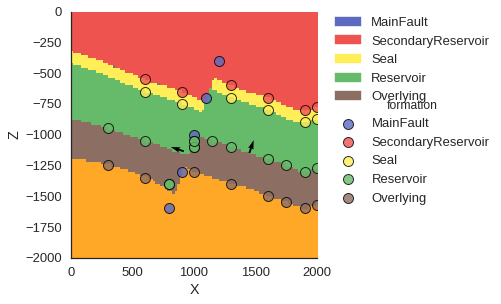

In [15]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], 50, plot_data=True)

In [82]:
ver_s, sim_s = gp.get_surfaces(interp_data,lith_block[1],
                               fault_block[1],
                               original_scale=False)

In [83]:
gp.plot_surfaces_3D_real_time(interp_data, ver_s, sim_s)

# 2D plots

In [18]:
ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)

In [19]:
# Some plotting options
params = {
    'axes.labelsize': 16,
    'font.size': 16,
    'legend.fontsize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': False,
    "axes.linewidth": 0.75,
    'xtick.major.size': 2,
    'xtick.major.width': 0.75,
    'ytick.major.size': 2,
    'ytick.major.width': 0.75,
}


def get_figsize(scale, textwidth=522, ratio=None):                      # Get this from LaTeX using \the\textwidth
    """Source: http://bkanuka.com/articles/native-latex-plots/"""
    inches_per_pt = 1.0 / 72.27                             # Convert pt to inch
    if ratio == None:
        ratio = (np.sqrt(5.0)-1.0)/2.0                    # Aesthetic ratio (you could change this)
    fig_width = textwidth * inches_per_pt * scale           # width in inches
    fig_height = fig_width * ratio                    # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

from matplotlib import rcParams
rcParams.update(params)

In [20]:
np.sort(vertices_list[0][1], axis=0)

array([[   0.        ,    0.        , -859.39918518],
       [   0.        ,    0.        , -859.2427063 ],
       [   0.        ,    0.        , -859.2427063 ],
       ...,
       [1980.        , 1980.        , -140.        ],
       [1980.        , 1980.        , -140.        ],
       [1980.        , 1980.        , -129.94338989]])

In [21]:
vertices_list[0][1]

array([[   0.        ,   17.79236317, -140.        ],
       [  20.        ,    0.        , -144.31121826],
       [  13.8780427 ,    0.        , -140.        ],
       ...,
       [1980.        , 1959.65240479, -720.        ],
       [1980.        , 1960.        , -719.85214233],
       [1980.        , 1980.        , -711.15325928]])

If a layer is folded through the axis x the plt.plot go nuts!!!

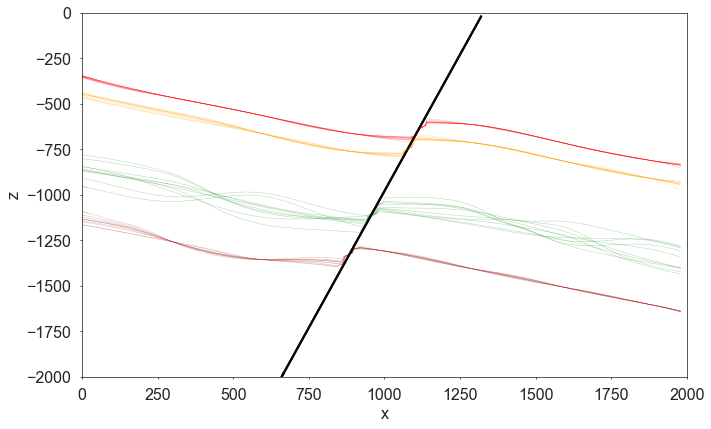

In [22]:
vertices = vertices_list

# Function to plot the traces with the vertices
def plot_iterline(i, l, color="black", lw=0.5):
   # f = vertices[i][l][:,1]==np.min(vertices[i][l][:,1])
   # f = a
    f = np.array(vertices[i][l][:,1] > 990) * np.array(vertices[i][l][:,1] < 1010)
    points = vertices[i][l][f]
    plt.plot(points[::1,0], points[::1,2], '-',
             #linestyle="solid",
             linewidth=lw, color=color, alpha=0.3)

fig = plt.figure(figsize=get_figsize(1.5))
ax = plt.subplot()
    
for i in range(0,len(vertices_list)):
    plot_iterline(i, 4, color="brown")
    plot_iterline(i, 3, color="green")
    plot_iterline(i, 2, color="orange")
    plot_iterline(i, 1, color="red")
    plot_iterline(i, 0, color="black", lw=2)
    
ax.set_xlabel("x")

plt.ylabel("z")
plt.xlim(0,2000)

plt.ylim(-2000,-0)

plt.grid(False)

In [82]:
# implementation in function

def plot_all_lines(vertices_list):
    np.sort(vertices_list[0][1], axis=0)
    vertices = vertices_list

    # Function to plot the traces with the vertices
    def plot_iterline(i, l, color="black", lw=0.5):
       # f = vertices[i][l][:,1]==np.min(vertices[i][l][:,1])
       # f = a
        f = np.array(vertices[i][l][:,1] > 990) * np.array(vertices[i][l][:,1] < 1010)
        points = vertices[i][l][f]
        plt.plot(points[::1,0], points[::1,2], '-',
                 #linestyle="solid",
                 linewidth=lw, color=color, alpha=0.3)

    fig = plt.figure(figsize=get_figsize(1.5))
    ax = plt.subplot()
    for i in range(0,len(vertices_list)):
        plot_iterline(i, 4, color="brown")
        plot_iterline(i, 3, color="green")
        plot_iterline(i, 2, color="orange")
        plot_iterline(i, 1, color="red")
        plot_iterline(i, 0, color="black", lw=2)

    ax.set_xlabel("x")
    plt.ylabel("z")
    plt.xlim(0,2000)
    plt.ylim(-2000,-0)
    plt.grid(False)

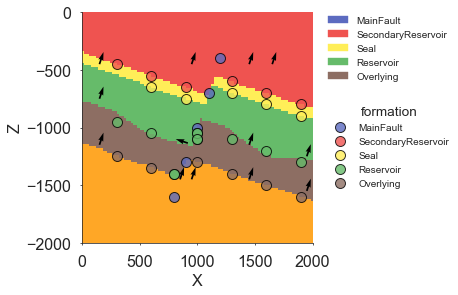

In [247]:
gp.plot_section(geo_data, lith_block[0], 50, plot_data=True)

### Prob

In [242]:
import gempy.UncertaintyAnalysisPYMC2 as uq
import importlib
importlib.reload(uq)

../gempy/UncertaintyAnalysisPYMC2.py:8: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


<module 'gempy.UncertaintyAnalysisPYMC2' from '../gempy/UncertaintyAnalysisPYMC2.py'>

In [243]:
p_i = uq.compute_prob_lith(lith_list)

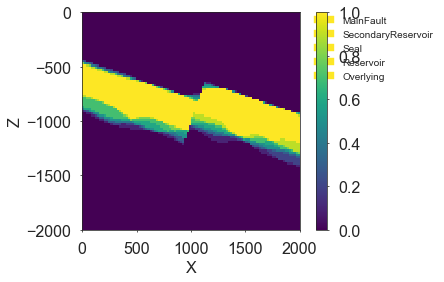

In [244]:
#previous vis does not work - conflict with cmaps...

plot_layer = 3

gp.plot_section(geo_data,p_i[plot_layer], 50, cmap='viridis', norm=None)
plt.colorbar()

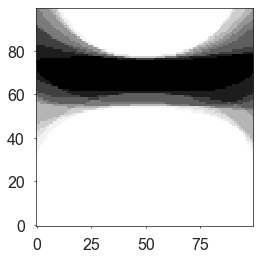

In [245]:
plt.imshow(p_i[3].reshape((100,100,100))[0].T, origin='upper left')

### Entropy

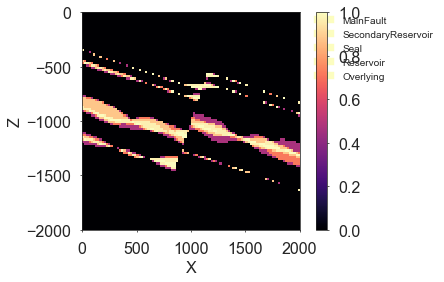

In [246]:

e = uq.calcualte_ie_masked(p_i)

gp.plot_section(geo_data,e, 50, cmap='magma', norm=None)
plt.colorbar()

## Random realisations with smooth transitions

Similar to before, but now creating samples and then filling space in-between with continuous samples to enable a smooth transition:

In [298]:
import matplotlib.pyplot as plt
import pandas as pd
import pyevtk as evtk

# n-random samples
n_rand = 4
# number of transition steps between realisations:
trans_steps = 5

# for now: only change reservoir top:
# determine ids of reservoir points:
res_ids = ori_data.interfaces['formation'] == 'Reservoir'
# get z_values from original model (for proper sampling):
z_vals_ori = ori_data.interfaces[res_ids]['Z']
# cast to array:
z_vals = np.array(z_vals_ori, dtype=np.float64)
# set stdev (consider ori val as mean):
z_res_stdev = 0.015

# list of all z_values:
z_values_all = []
# initialize with original model values:
z_values_all.append(z_vals)

# generate random samples:

z_vals_rand = []

z_vals_prev = z_vals.copy()
for i in range(n_rand):
    
    # ***** adjusted own implementation ****
    # draw new values:
    z_vals_new = nrand.normal(loc=z_vals, scale=z_res_stdev)
    
    z_vals_rand.append(z_vals_new)
    
    # fill space in-between:
    z_diff = (z_vals_new - z_vals_prev) / (trans_steps + 1)
    z_diff_array = np.cumsum(np.tile(z_diff, (trans_steps,1)), axis=0)
    for k in range(trans_steps):
        z_values_all.append(z_vals_prev + z_diff_array[k])
        
    # finally, add final value
    z_values_all.append(z_vals_new)
    # update prev array
    z_vals_prev = z_vals_new.copy()
        
    
    

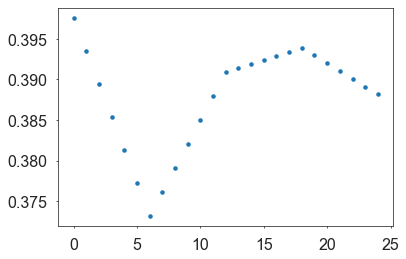

In [299]:
tmp = np.array(z_values_all)

plt.plot(tmp[:,0], '.')

## Next attempt: smooth random transitions with sigmoid function

In [38]:
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

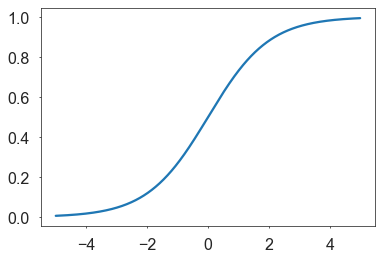

In [43]:
xvals = np.arange(-5,5,0.01)
plt.plot(xvals, sigmoid(xvals))

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import pyevtk as evtk

# n-random samples
n_rand = 10
# number of transition steps between realisations:
trans_steps = 10


# define sigomid steps - same for all:
sigmoid_steps = sigmoid(np.linspace(-5,5,trans_steps))

# for now: only change reservoir top:
# determine ids of reservoir points:
res_ids = ori_data.interfaces['formation'] == 'Reservoir'
# get z_values from original model (for proper sampling):
z_vals_ori = ori_data.interfaces[res_ids]['Z']
# cast to array:
z_vals = np.array(z_vals_ori, dtype=np.float64)
# set stdev (consider ori val as mean):
z_res_stdev = 0.02

# list of all z_values:
z_values_all = []
# initialize with original model values:
z_values_all.append(z_vals)

# generate random samples:

z_vals_rand = []

z_vals_prev = z_vals.copy()
for i in range(n_rand):
    
    # ***** adjusted own implementation ****
    # draw new values:
    z_vals_new = nrand.normal(loc=z_vals, scale=z_res_stdev)
    
    z_vals_rand.append(z_vals_new)
    
    # fill space in-between:
    z_diff = (z_vals_new - z_vals_prev) #  (trans_steps + 1)
    
    # tile sigmoid function:
    sigmoid_vals = np.tile(sigmoid_steps, (len(z_diff),1))
    z_diff_array = np.multiply(sigmoid_vals.T, z_diff)
    
    # z_diff_array = np.cumsum(np.tile(z_diff, (trans_steps,1)), axis=0)
    for k in range(trans_steps):
        z_values_all.append(z_vals_prev + z_diff_array[k])
        
    # finally, add final value
    z_values_all.append(z_vals_new)
    # update prev array
    z_vals_prev = z_vals_new.copy()
        
    
    

In [45]:
sigmoid_vals = np.tile(sigmoid_steps, (5,1))
diff = np.arange(1,6)
z = np.multiply(sigmoid_vals.T, diff)

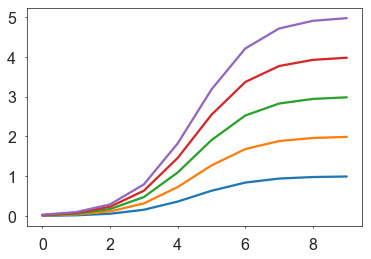

In [46]:
plt.plot(z)

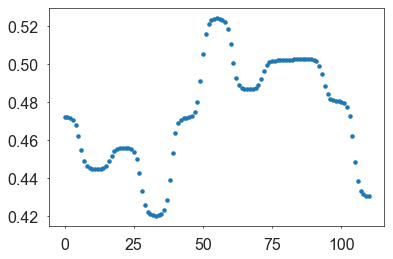

In [47]:
tmp = np.array(z_values_all)

plt.plot(tmp[:,0], '.')

In [48]:
# Lists for probability and ploting vertices
lith_list = np.zeros((0, lith_block[0].shape[-1]), dtype='int')
vertices_list = []
z_vals_list = []
for i in range(len(z_values_all)):
    
    # **** previous version by Miguel ****
    # Changing the interp
#     interp_data.geo_data_res.interfaces['Z'] = interp_data.geo_data_res.interfaces['Z'] + \
#                                              np.ones_like(interp_data.geo_data_res.interfaces['Z'])*0.001* np.random.choice([-1,1],
#                                              size = interp_data.geo_data_res.interfaces['Z'].shape[0])
        
    

    # assign values to data:
    interp_data.geo_data_res.interfaces.loc[
        interp_data.geo_data_res.interfaces['formation'] == 'Reservoir','Z'] \
        = z_values_all[i]
#     interp_data.geo_data_res.interfaces[res_ids]['Z'].set_values(z_vals_new)
#     new_df = pd.DataFrame({'Z' : z_vals_new})
#     interp_data.geo_data_res.interfaces[res_ids].update(new_df)
        
    # testing
    # print(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'][:3])
    # print(z_vals_new[:3])
    
    # Compute
    lith_block, fault_block = gp.compute_model(interp_data)
    
    # Vertices
    ver, sim = gp.get_surfaces(interp_data, lith_block[1], fault_block[1], original_scale=True)
    
    lith_list = np.vstack((lith_list,lith_block[0]))
    vertices_list.append(ver)
    
    # Exporting both lith block and surfaces. name goes after path: This is because of how paraview reads numbers to define frames
    gp.export_to_vtk(geo_data, path='./vtks/', name='m'+str(i), lith_block=lith_block[0], vertices=ver,
                    simplices=sim)
    
    print(i)
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


In [371]:
np.sort(vertices_list[0][1], axis=0)

array([[   0.        ,    0.        , -836.36535645],
       [   0.        ,    0.        , -836.36535645],
       [   0.        ,    0.        , -836.10397339],
       ...,
       [1980.        , 1980.        ,  -20.        ],
       [1980.        , 1980.        ,  -20.        ],
       [1980.        , 1980.        ,  -20.        ]])

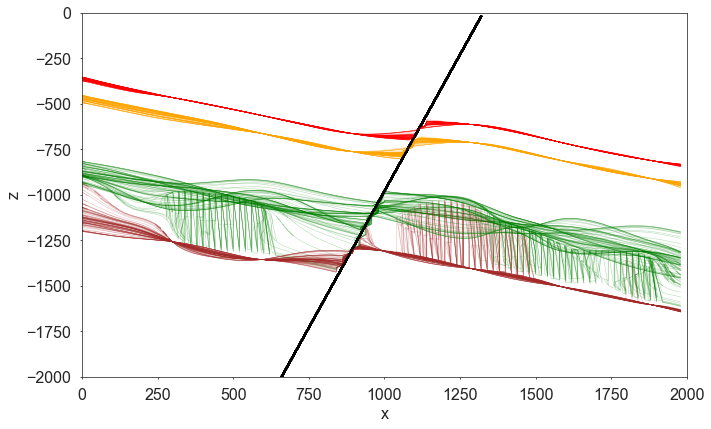

In [49]:
vertices = vertices_list

# Function to plot the traces with the vertices
def plot_iterline(i, l, color="black", lw=0.5):
   # f = vertices[i][l][:,1]==np.min(vertices[i][l][:,1])
   # f = a
    f = np.array(vertices[i][l][:,1] > 990) * np.array(vertices[i][l][:,1] < 1010)
    points = vertices[i][l][f]
    plt.plot(points[::1,0], points[::1,2], '-',
             #linestyle="solid",
             linewidth=lw, color=color, alpha=0.3)

fig = plt.figure(figsize=get_figsize(1.5))
ax = plt.subplot()
    
for i in range(0,len(vertices_list)):
    plot_iterline(i, 4, color="brown")
    plot_iterline(i, 3, color="green")
    plot_iterline(i, 2, color="orange")
    plot_iterline(i, 1, color="red")
    plot_iterline(i, 0, color="black", lw=2)
    
ax.set_xlabel("x")

plt.ylabel("z")
plt.xlim(0,2000)

plt.ylim(-2000,-0)

plt.grid(False)

## Use side sections

Next idea: use sections front/ back to change entire reservoir behaviour consistently (check: use ID's in initial pandas data frame)


In [51]:
interp_data.geo_data_res.interfaces

,X,Y,Z,formation,ID,series,order_series,isFault,formation_number,annotations
0,0.430656,0.5001,0.333433,MainFault,NaN,fault,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
1,0.458433,0.5001,0.416767,MainFault,NaN,fault,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
2,0.513989,0.5001,0.583433,MainFault,NaN,fault,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},2}$"
3,0.541767,0.5001,0.666767,MainFault,NaN,fault,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},3}$"
4,0.486211,0.5001,0.5001,MainFault,NaN,fault,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},4}$"
5,0.486211,0.7501,0.611211,SecondaryReservoir,Back,Rest,2,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$"
6,0.486211,0.2501,0.611211,SecondaryReservoir,Front,Rest,2,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$"
7,0.458433,0.5001,0.597322,SecondaryReservoir,NaN,Rest,2,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},2}$"
8,0.3751,0.5001,0.6251,SecondaryReservoir,NaN,Rest,2,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},3}$"
9,0.291767,0.5001,0.652878,SecondaryReservoir,NaN,Rest,2,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},4}$"


In [56]:
vertices, simplices = gp.get_surfaces(interp_data,lith_block[1],
                               fault_block[1],
                               original_scale=False)
gp.plot_surfaces_3D(geo_data, vertices, simplices)

In [59]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 100,100,100],
                          path_f = os.pardir+"/input_data/FW_2_Foliations.csv", 
                          path_i = os.pardir+"/input_data/FW_3_Points.csv")


../gempy/DataManagement.py:438: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../gempy/DataManagement.py:441: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


In [60]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest": ('SecondaryReservoir','Seal', 'Reservoir', 'Overlying')},
                       order_series = ["fault", 'Rest'],
                       order_formations=['MainFault', 
                                         'SecondaryReservoir', 'Seal','Reservoir', 'Overlying',
                                         ], verbose=0) 

../gempy/DataManagement.py:438: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../gempy/DataManagement.py:441: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


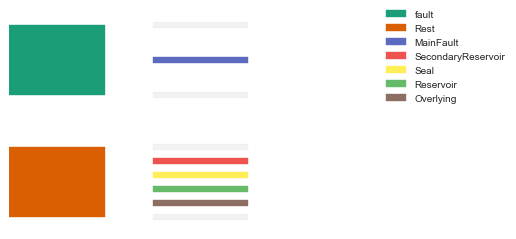

In [61]:
%matplotlib inline
gp.get_sequential_pile(geo_data)

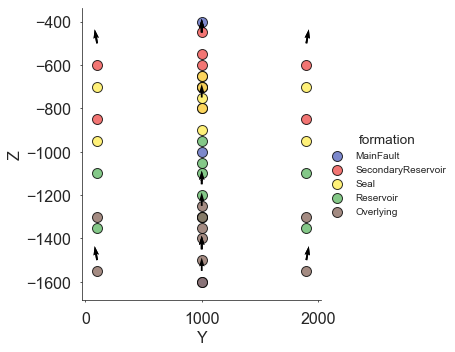

In [62]:
%matplotlib inline
gp.plot_data(geo_data, direction='x')

In [63]:
gp.plot_data_3D(geo_data)

In [64]:
interp_data = gp.InterpolatorInput(geo_data, u_grade=[3,0], dtype="float64")
print(interp_data)

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [66]:
lith_block, fault_block = gp.compute_model(interp_data)

In [69]:
vertices, simplices = gp.get_surfaces(interp_data,lith_block[1],
                               fault_block[1],
                               original_scale=False)

In [67]:
gp.plot_surfaces_3D(geo_data, vertices, simplices)

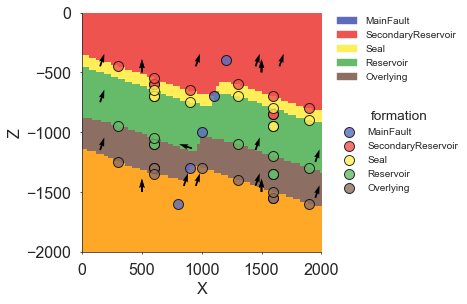

In [77]:
gp.plot_section(geo_data, lith_block[0], 50, direction='y', plot_data=True)

In [78]:
## Own implementation to avoid "extreme" cases (no continues updating, always reverting to original model)
import copy 
ori_data = copy.deepcopy(interp_data.geo_data_res)


In [79]:
z_vals = ori_data.interfaces[ori_data.interfaces['formation'] == 'Reservoir']['Z']
z_vals

24    0.472322
25    0.472322
26    0.402878
27    0.402878
28    0.486211
29    0.513989
30    0.444544
31    0.472322
32    0.416767
Name: Z, dtype: object

In [80]:
z_vals = np.array(z_vals, dtype=np.float64)

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import pyevtk as evtk

# n-random samples
n_rand = 5
# number of transition steps between realisations:
trans_steps = 10


# define sigomid steps - same for all:
sigmoid_steps = sigmoid(np.linspace(-5,5,trans_steps))

# for now: only change reservoir top:
# determine ids of reservoir points:
res_ids = ori_data.interfaces['formation'] == 'Reservoir'
# get z_values from original model (for proper sampling):
z_vals_ori = ori_data.interfaces[res_ids]['Z']
# cast to array:
z_vals = np.array(z_vals_ori, dtype=np.float64)
# set stdev (consider ori val as mean):
z_res_stdev = 0.015

# list of all z_values:
z_values_all = []
# initialize with original model values:
z_values_all.append(z_vals)

# generate random samples:

z_vals_rand = []

z_vals_prev = z_vals.copy()
for i in range(n_rand):
    
    # ***** adjusted own implementation ****
    # draw new values:
    z_vals_new = nrand.normal(loc=z_vals, scale=z_res_stdev)
    
    z_vals_rand.append(z_vals_new)
    
    # fill space in-between:
    z_diff = (z_vals_new - z_vals_prev) #  (trans_steps + 1)
    
    # tile sigmoid function:
    sigmoid_vals = np.tile(sigmoid_steps, (len(z_diff),1))
    z_diff_array = np.multiply(sigmoid_vals.T, z_diff)
    
    # z_diff_array = np.cumsum(np.tile(z_diff, (trans_steps,1)), axis=0)
    for k in range(trans_steps):
        z_values_all.append(z_vals_prev + z_diff_array[k])
        
    # finally, add final value
    z_values_all.append(z_vals_new)
    # update prev array
    z_vals_prev = z_vals_new.copy()
        
    
    

In [84]:
from ipywidgets import FloatProgress
from IPython.display import display
import time

max_count = 100

f = FloatProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

count = 0
while count <= max_count:
    f.value += 1 # signal to increment the progress bar
    time.sleep(.05)
    count += 1

FloatProgress(value=0.0)

In [ ]:
# Lists for probability and ploting vertices
lith_list = np.zeros((0, lith_block[0].shape[-1]), dtype='int')
vertices_list = []
z_vals_list = []

# here set-up for progress bar
f = FloatProgress(min=0, max=len(z_values_all)) # instantiate the bar
display(f) # display the bar

for i in range(len(z_values_all)):
    
    # **** previous version by Miguel ****
    # Changing the interp
#     interp_data.geo_data_res.interfaces['Z'] = interp_data.geo_data_res.interfaces['Z'] + \
#                                              np.ones_like(interp_data.geo_data_res.interfaces['Z'])*0.001* np.random.choice([-1,1],
#                                              size = interp_data.geo_data_res.interfaces['Z'].shape[0])
        
    

    # assign values to data:
    interp_data.geo_data_res.interfaces.loc[
        interp_data.geo_data_res.interfaces['formation'] == 'Reservoir','Z'] \
        = z_values_all[i]
#     interp_data.geo_data_res.interfaces[res_ids]['Z'].set_values(z_vals_new)
#     new_df = pd.DataFrame({'Z' : z_vals_new})
#     interp_data.geo_data_res.interfaces[res_ids].update(new_df)
        
    # testing
    # print(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'][:3])
    # print(z_vals_new[:3])
    
    # Compute
    lith_block, fault_block = gp.compute_model(interp_data)
    
    # Vertices
    ver, sim = gp.get_surfaces(interp_data, lith_block[1], fault_block[1], original_scale=True)
    
    lith_list = np.vstack((lith_list,lith_block[0]))
    vertices_list.append(ver)
    
    # Exporting both lith block and surfaces. name goes after path: This is because of how paraview reads numbers to define frames
    gp.export_to_vtk(geo_data, path='./vtks/', name='m'+str(i), lith_block=lith_block[0], vertices=ver,
                    simplices=sim)
    
    # update progress bar
    f.value += 1 # signal to increment the progress bar

   

FloatProgress(value=0.0, max=56.0)

In [ ]:
# generate line plot
plot_all_lines(vertices_list)